In [59]:
%matplotlib inline  
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.hodgkin_huxley import HH
from neurodynex.tools import input_factory



## 6.1. Exercise: step current response

### 6.1.1

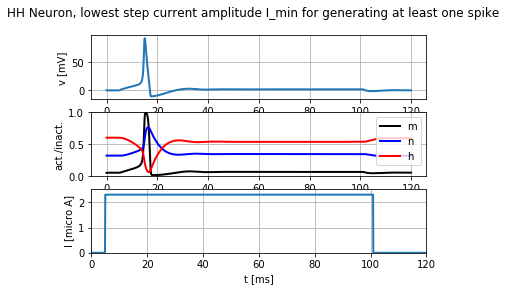

In [60]:
I_min=2.30# lowest step current amplitude I_min for generating at least one spike
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, 120 * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron, lowest step current amplitude I_min for generating at least one spike")

### 6.1.2

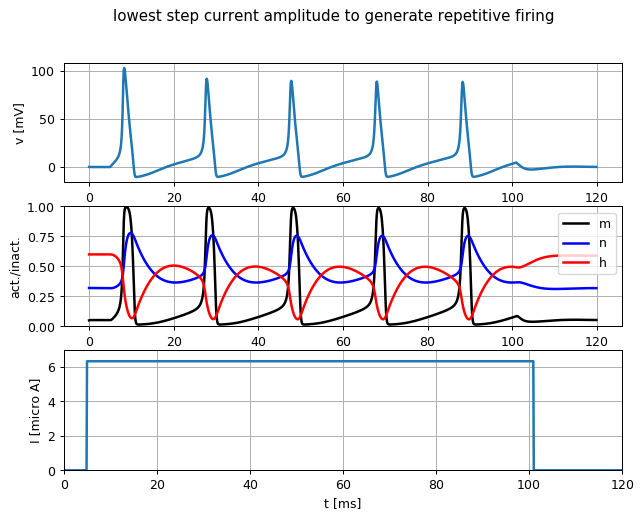

In [61]:

I_min=6.32 #lowest step current amplitude to generate repetitive firing
t_max=100
plt.figure(figsize=(8, 6), dpi=90)
current = input_factory.get_step_current(5, t_max, b2.ms, I_min *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, (t_max+20) * b2.ms)
HH.plot_data(state_monitor, title="lowest step current amplitude to generate repetitive firing")

## 6.2. Exercise: slow and fast ramp current

The minimal current to elicit a spike does not just depend on the amplitude I or on the total charge Q of the current, but on the “shape” of the current. Let’s see why

### 6.2.1
Inject a slow ramp current into a HH neuron. The current has amplitude 0A at t in [0, 5] ms and linearly increases to an amplitude I_min_slow at t=50ms. At t>50ms, the current is set to 0A. What is the minimal amplitude I_min_slow to trigger one spike (vm>50mV)?

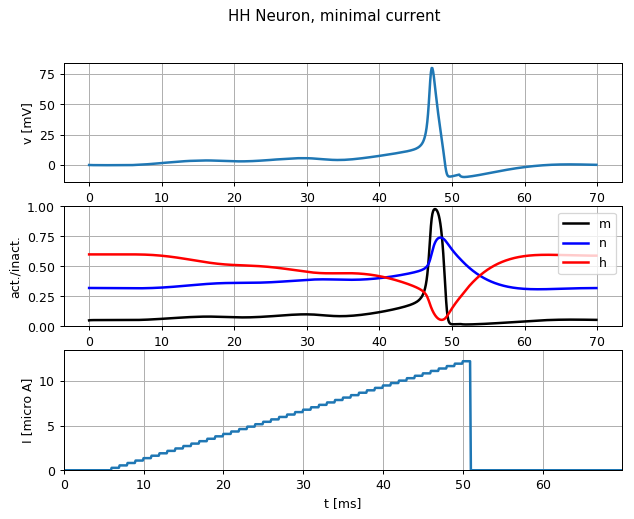

In [53]:
I_min_slow=12.21
t_max=50
slow_ramp_current = input_factory.get_ramp_current(5, t_max, b2.ms, 0.*b2.uA, I_min_slow *b2.uA)
state_monitor = HH.simulate_HH_neuron(slow_ramp_current, (t_max+20) * b2.ms)
plt.figure(figsize=(8, 6), dpi=90)
HH.plot_data(state_monitor, title="HH Neuron,  slow ramp current :I_min_slow=12.21")

### 6.2.2
Now inject a fast ramp current into a HH neuron. The current has amplitude 0 at t in [0, 5] ms and linearly increases to an amplitude I_min_fast at t=10ms. At t>10ms, the current is set to 0A. What is the minimal amplitude I_min_fast to trigger one spike? Note: Technically the input current is implemented using a TimedArray. For a short, steep ramp, the one milliseconds discretization for the current is not high enough. You can create a more fine resolution:

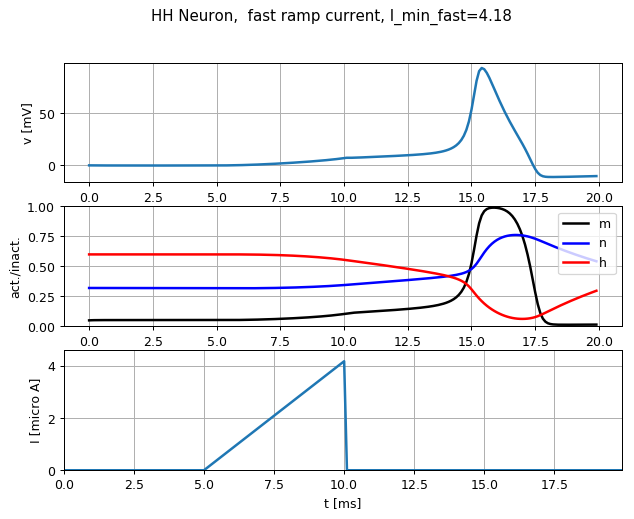

In [62]:
I_min_fast=4.18
t_max=10
plt.figure(figsize=(8, 6), dpi=90)
fast_ramp_current = input_factory.get_ramp_current(50, 100, 0.1*b2.ms, 0.*b2.uA, I_min_fast *b2.uA)
state_monitor = HH.simulate_HH_neuron(fast_ramp_current, (t_max+10) * b2.ms)
HH.plot_data(state_monitor, title="HH Neuron,  fast ramp current, I_min_fast=4.18 ")


### 6.2.3.
Compare the two previous results. By looking at the gating variables m,n, and h, can you explain the reason for the differences in that “current threshold”? Hint: have a look at Chapter 2 Figure 2.3 b

-> h decrease more for a slow ramp current-> greater amplitude to pass the threshold

## 6.3. Exercise: Rebound Spike
A HH neuron can spike not only if it receives a sufficiently strong depolarizing input current but also after a hyperpolarizing current. Such a spike is called a rebound spike.

### 6.3.1. Question
Inject a hyperpolarizing step current I_amp = -1 uA for 20ms into the HH neuron. Simulate the neuron for 50 ms and plot the voltage trace and the gating variables. Repeat the simulation with I_amp = -5 uA What is happening here? To which gating variable do you attribute this rebound spike?

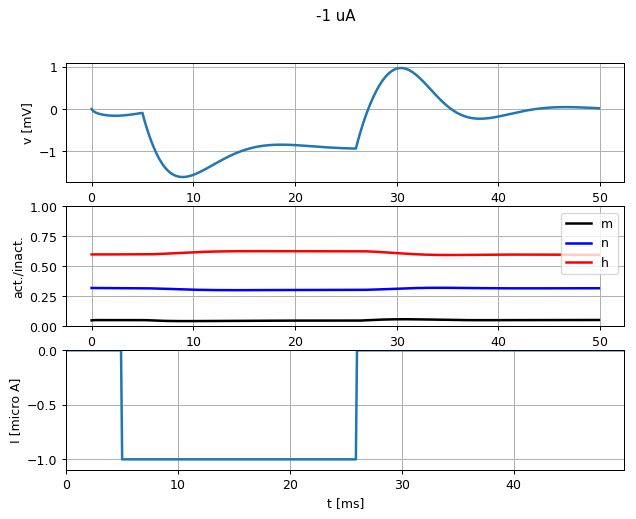

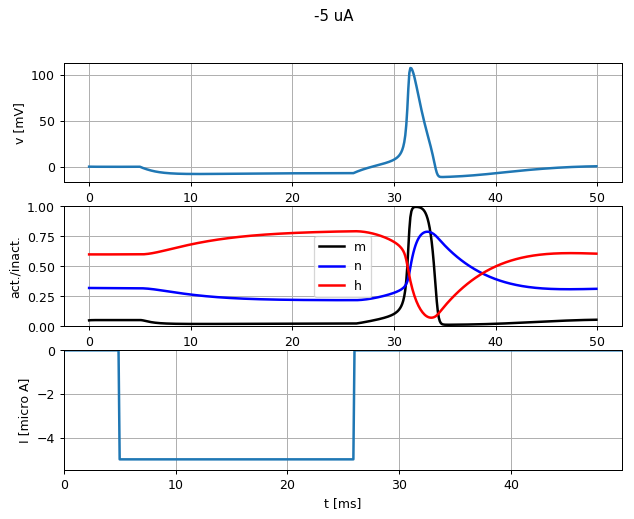

In [56]:
t_max=25
plt.figure(figsize=(8, 6), dpi=90)
current = input_factory.get_step_current(5, t_max, b2.ms,-1 *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, (50) * b2.ms)
HH.plot_data(state_monitor, title="-1 uA")

t_max=25
plt.figure(figsize=(8, 6), dpi=90)
current = input_factory.get_step_current(5, t_max, b2.ms,-5 *b2.uA)
state_monitor = HH.simulate_HH_neuron(current, (50) * b2.ms)
HH.plot_data(state_monitor, title="-5 uA")

A simple explanation of the transient spike is that the peak of the membrane potential oscillation after the step reaches the voltage threshold for spike initiation, so that a single action potential is triggered. It is indeed the subthreshold oscillations that underly the transient spiking


h is suffenciently high for an AP.



## 6.4. Exercise: Brian implementation of a HH neuron
### 6.4.1. 
In the source code of your function simulate_modified_HH_neuron, change the density of sodium channels. Increase it by a factor of 1.4. Stimulate this modified neuron with a step current.

What is the current threshold for repetitive spiking? Explain.

1.11mV and before it was 6.32mV
increase the density of channel, increase the self renforcing response, therefor less current is needed to fire an action potential


Run a simulation with no input current to determine the resting potential of the neuron. Bonus: link your observation to the Goldman–Hodgkin–Katz voltage equation.
we increased the sodium permeability of the membrane and therefore the resting membrane potential, -> V stabilize at 0.5mV instead of 0mV




If you increase the sodium conductance further, you can observe repetitive firing even in the absence of input, why?
it's increase the resting membrane potential-> which will be greater than the threshold to fire an AP therfore the neuron will fire an AP repetitively 

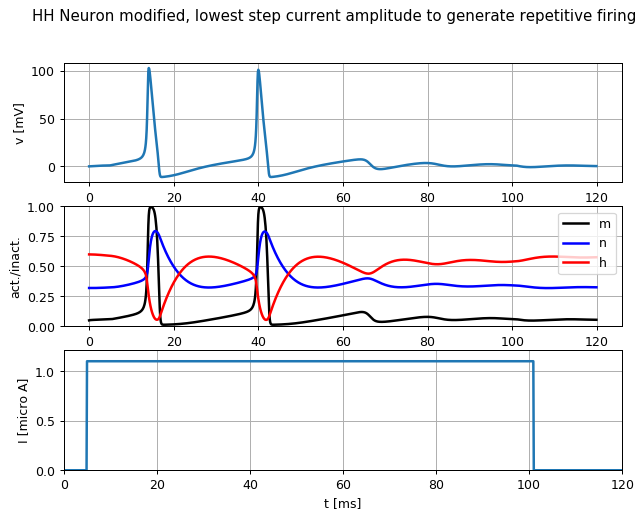

In [89]:
def simulate_modified_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120*1.4 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

I_min=1.1# lowest step current amplitude to generate repetitive firing
current = input_factory.get_step_current(5, 100, b2.ms, I_min *b2.uA)
state_monitor = simulate_modified_HH_neuron(current, 120 * b2.ms)
plt.figure(figsize=(8, 6), dpi=90)
HH.plot_data(state_monitor, title="HH Neuron modified, lowest step current amplitude to generate repetitive firing")